In [358]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [359]:
from preprocessing import preprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import shap

# Load data

In [288]:
data = pd.read_csv("./data/Spotify_Youtube.csv", index_col=0)
y = data["Stream"]
X = data.drop(columns=["Uri", "Url_spotify", "Url_youtube", "Stream"])

In [360]:
# hold out sample
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

# Feature distribution

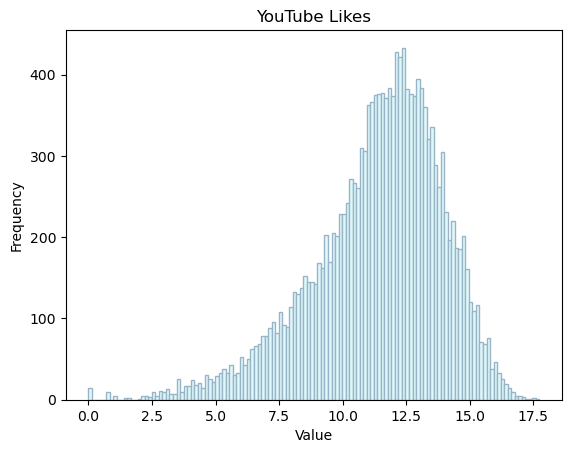

In [174]:
plt.hist(
    np.log1p(X_train["Likes"]),
    bins=int(len(X_train) ** 0.5), 
    edgecolor="#98b5c8", 
    color="#dff9fb"
)
plt.title("YouTube Likes")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

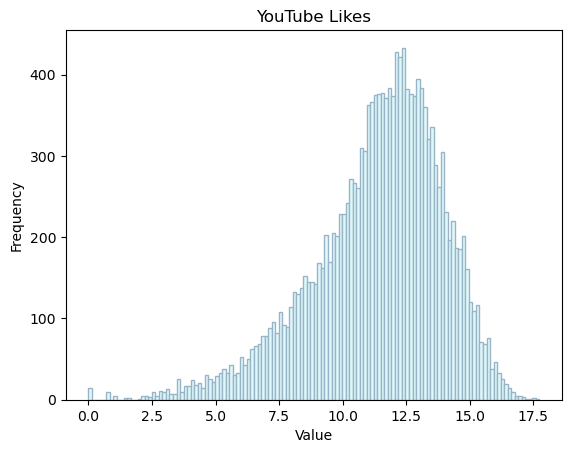

In [175]:
np.log1p(X_train["Likes"]).plot(kind="hist", 
                                bins=int(len(X_train) ** 0.5), 
                                edgecolor="#98b5c8", 
                                color="#dff9fb",
                                title='YouTube Likes')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

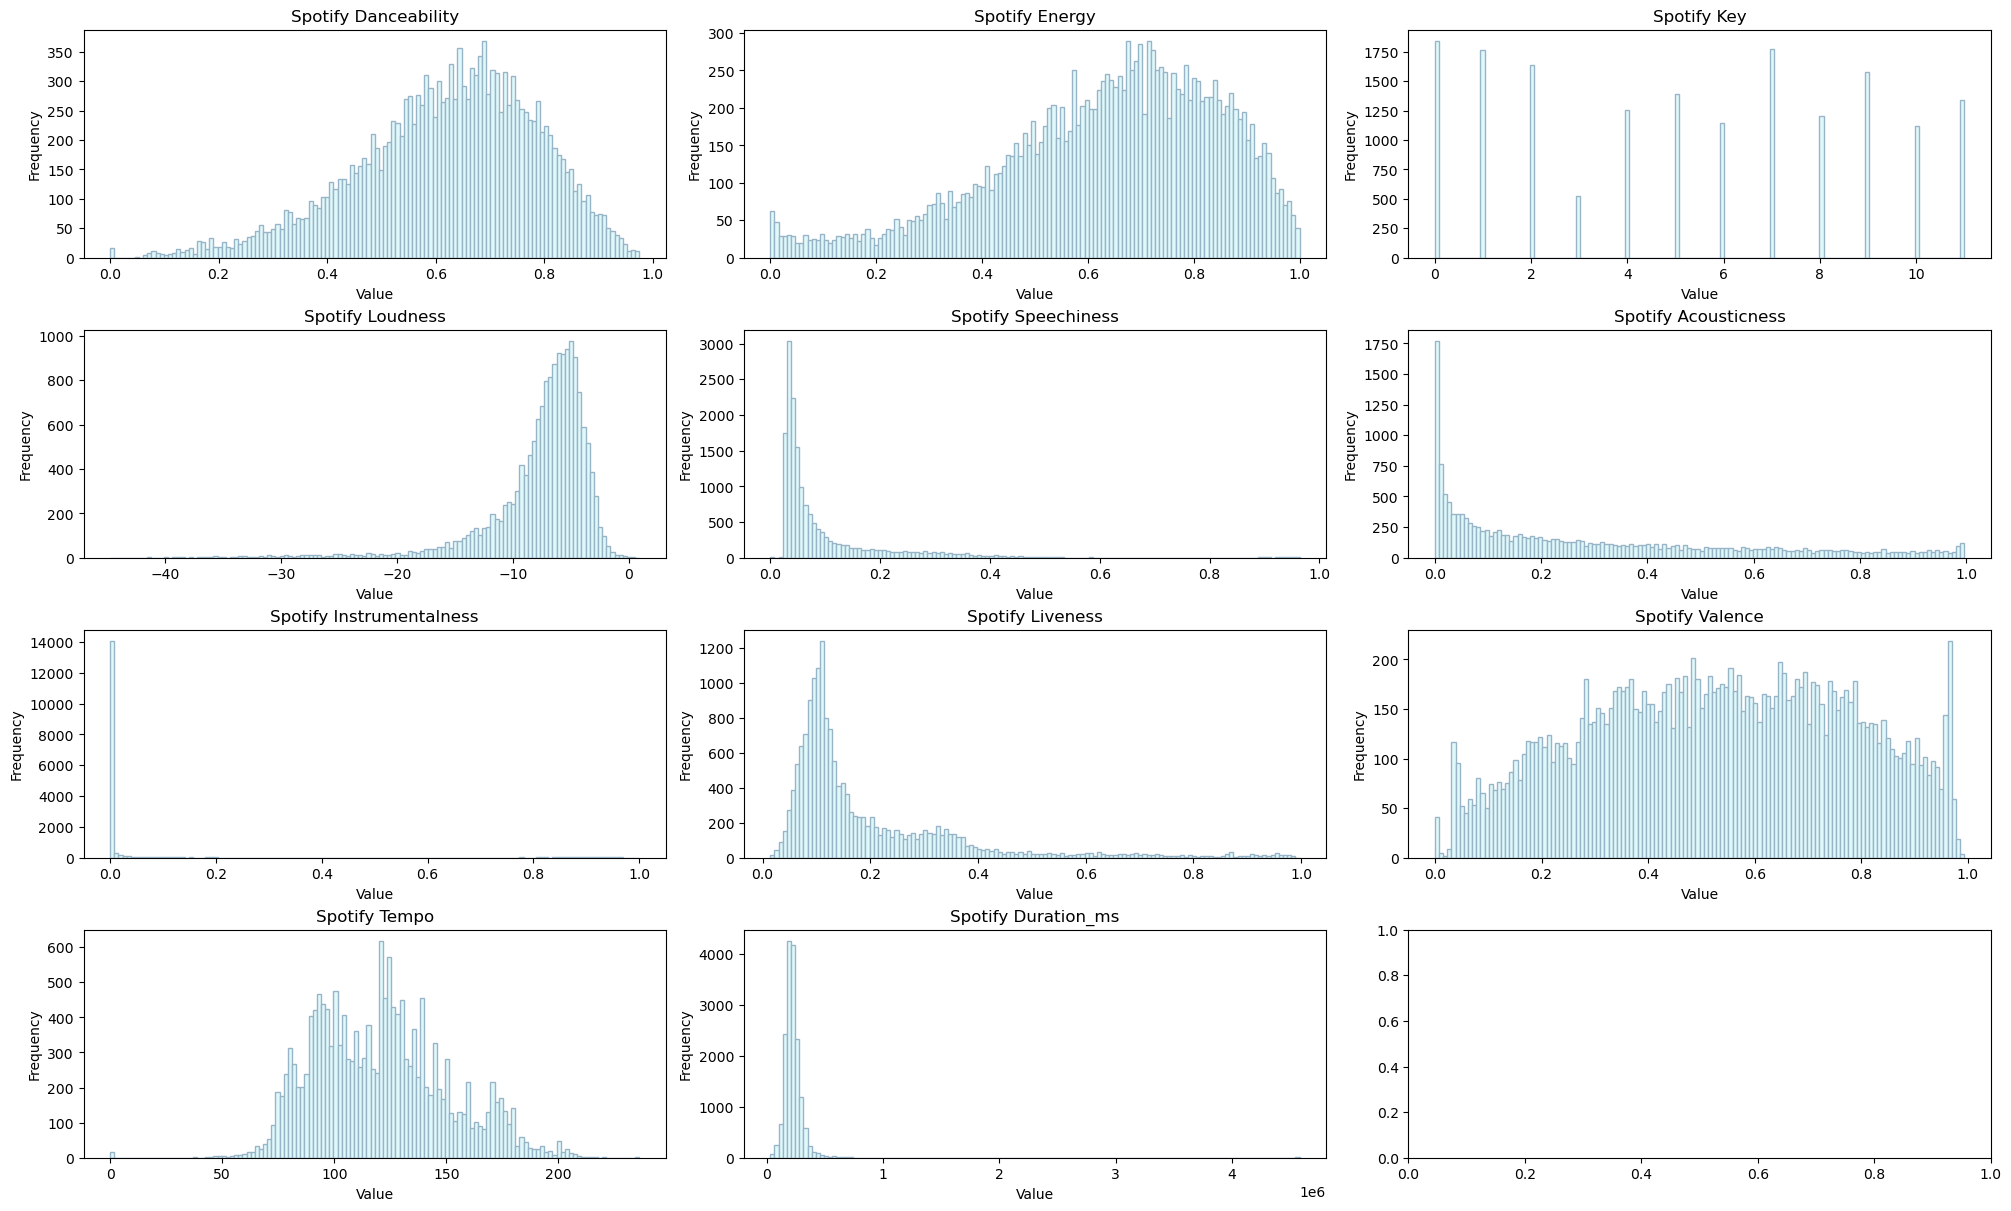

In [176]:
spotify_features = [
    "Danceability", "Energy", "Key", "Loudness", "Speechiness",
    "Acousticness", "Instrumentalness", "Liveness", "Valence",
    "Tempo", "Duration_ms"
]
fig, axes = plt.subplots(4, 3, figsize=(20, 12), constrained_layout=True)
axes = axes.ravel()
for i, f in enumerate(spotify_features):
    axes[i].hist(
        X_train[f],
        bins=int(len(X_train) ** 0.5),
        edgecolor="#98b5c8", 
        color="#dff9fb"
    )
    axes[i].set_title(f"Spotify {f}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel('Frequency')

plt.show()

# Preprocessing

In [361]:
X_train, X_val = preprocess(X_train=X_train, X_val=X_val).values()

Convert Album_type to one-hot (3)
Convert Channel to one-hot (30)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


In [363]:
X_train.head()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,...,Channel_UPROXX Video,Channel_EUROPA Hörspiele,Channel_PopArt Discos,Channel_CrhymeTV,Channel_Hear This Music,Channel_30PRAUM,Channel_Martin Garrix,Channel_JYP Entertainment,Channel_Orochi,Channel_Bruno Mars
0,0.400,0.571,1.599214,0.244116,0.0288,0.4680,0.000030,0.519,0.146,-1.984322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.676,0.731,1.039461,0.520920,0.0368,0.0438,0.000013,0.624,0.812,1.000986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.572,0.914,0.759584,-0.166877,0.0311,0.0717,0.007760,0.319,0.843,-0.390706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.813,0.627,1.599214,0.571700,0.0486,0.0771,0.000616,0.131,0.801,0.320017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.732,0.506,0.479707,-0.879739,0.0462,0.6880,0.000001,0.146,0.867,0.195387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model
## XGBoost

In [ ]:
xgb_model_params = {
    "n_estimators": 600,
    "learning_rate": 0.1,
    "objective": "reg:absoluteerror",
    "eval_metric": ["mae", "rmse"],
    "random_state": 42
}
xgb_fit_params = {
    "X": X_train,
    "y": y_train,
    "eval_set": [(X_train, y_train), (X_val, y_val)],
    "verbose": False
}

# build base model
xgb_model = XGBRegressor(**xgb_model_params)
xgb_model.fit(**xgb_fit_params)